In [1]:
!pip install git+https://github.com/imanring/Cox_Hawkes_Cov.git

  Cloning https://github.com/imanring/Cox_Hawkes_Cov.git to /tmp/pip-req-build-pw1jcocz
  Running command git clone --filter=blob:none --quiet https://github.com/imanring/Cox_Hawkes_Cov.git /tmp/pip-req-build-pw1jcocz
  Resolved https://github.com/imanring/Cox_Hawkes_Cov.git to commit 8ed9eb01f8c818350247d0d809de920be67e1897
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for BSTPP, since package 'wheel' is not installed.
  Running setup.py install for BSTPP ... done


In [1]:
from bstpp.main import Point_Process_Model

/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpyro.distributions as dist
import numpy as np

In [3]:
A = np.array([[3,15.5],[4,16.5]])
model_name = 'lgcp'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,
                            spatial_cov='data/spatial_cov.csv',interpolation=True,a_0=dist.Normal(0,5))

In [4]:
import pickle
pre_run = False
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc()

sample: 100%|█| 1500/1500 [00:22<00:00, 66.21it/s, 255 steps of s



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -2.97      0.57     -2.95     -3.85     -1.96    322.73      1.00
          w[0]      0.75      0.07      0.75      0.63      0.86   1039.55      1.00
          w[1]      0.15      0.03      0.15      0.10      0.20    902.06      1.00
          w[2]      0.28      0.02      0.28      0.24      0.32   1055.10      1.00
          w[3]     -0.79      0.05     -0.79     -0.87     -0.71    968.79      1.00
          w[4]      0.37      0.03      0.37      0.32      0.41   1067.95      1.00
          w[5]      0.34      0.03      0.34      0.30      0.39   1212.21      1.00
          w[6]     -0.23      0.03     -0.23     -0.28     -0.19   1045.70      1.00
          w[7]     -0.34      0.03     -0.35     -0.39     -0.30    821.20      1.00
          w[8]      0.92      0.05      0.92      0.84      1.01    941.14      1.00
          w[9]      0.01      0.03      0.01     -0.03      0.06

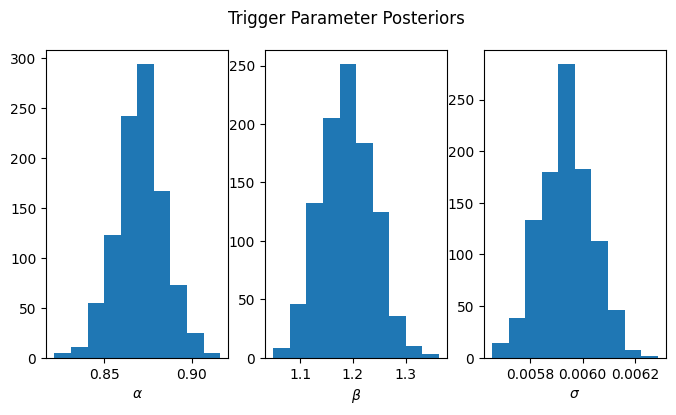

In [10]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

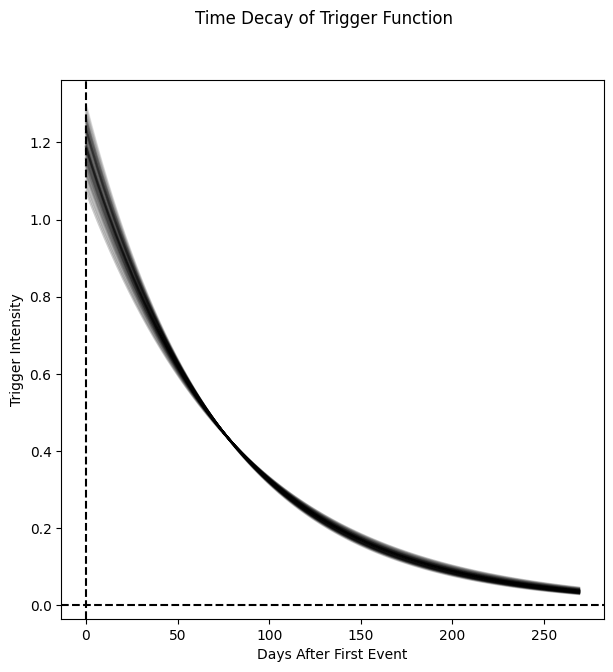

Mean trigger time: 76.9 days


In [11]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

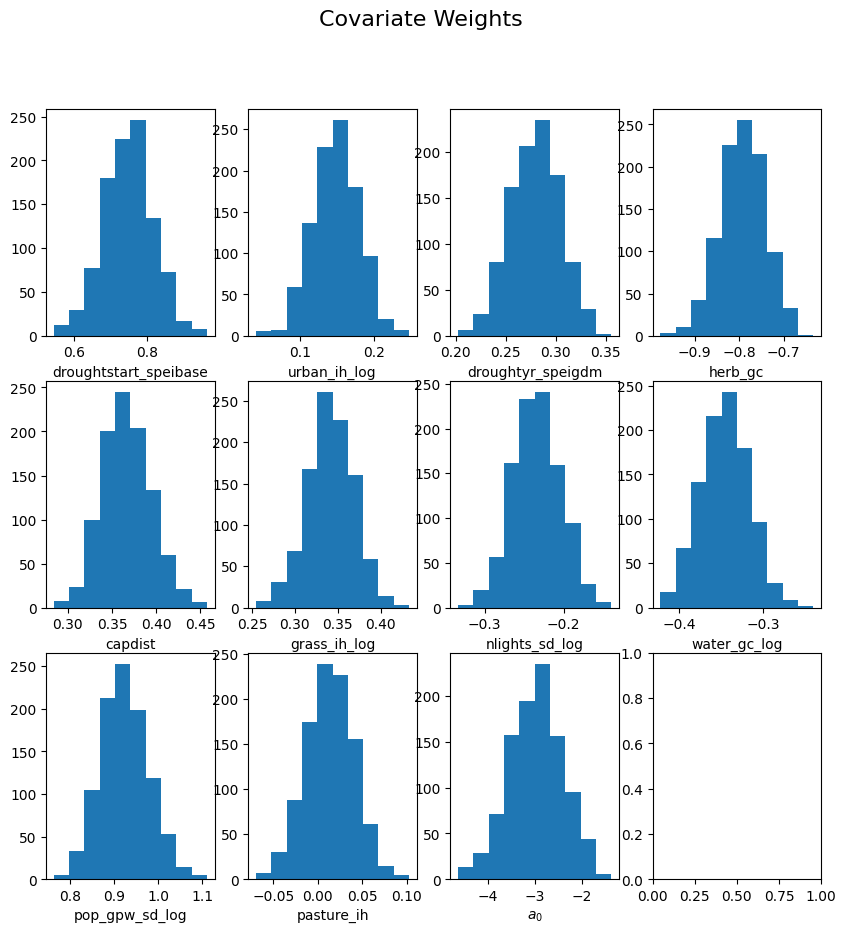

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,0.749580,0.068774,10.899165,0.000000e+00,0.611670,0.881521
urban_ih_log,0.147848,0.031189,4.740448,2.132466e-06,0.088432,0.206067
droughtyr_speigdm,0.279836,0.024795,11.285859,0.000000e+00,0.230593,0.327782
herb_gc,-0.791480,0.050523,-15.665824,0.000000e+00,-0.891979,-0.697720
capdist,0.366926,0.027845,13.177663,0.000000e+00,0.314319,0.423228
grass_ih_log,0.341462,0.027175,12.565131,0.000000e+00,0.286023,0.390978
nlights_sd_log,-0.233992,0.030051,-7.786545,6.883383e-15,-0.293551,-0.175758
water_gc_log,-0.344886,0.029296,-11.772505,0.000000e+00,-0.401008,-0.289022
pop_gpw_sd_log,0.924711,0.054526,16.959135,0.000000e+00,0.825347,1.037550
pasture_ih,0.013824,0.026793,0.515950,6.058893e-01,-0.040362,0.065489


In [5]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

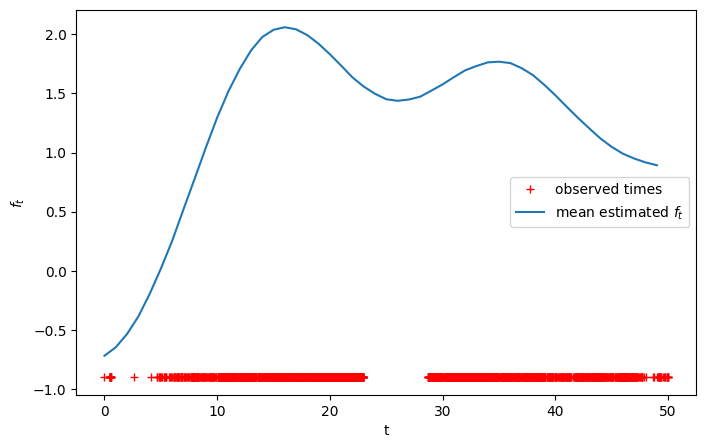

In [6]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

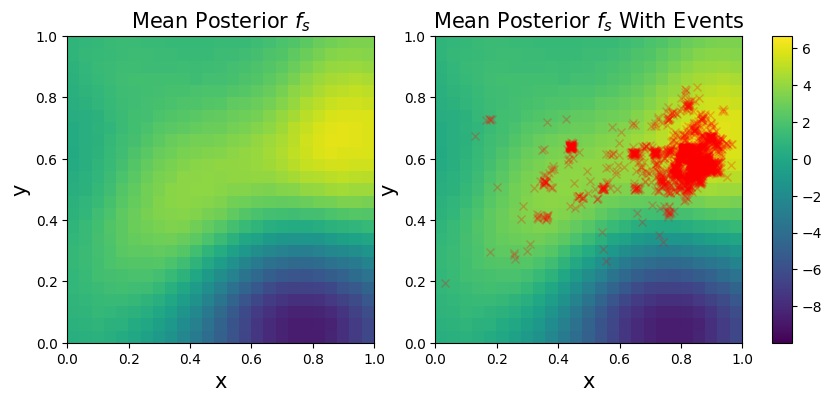

In [7]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

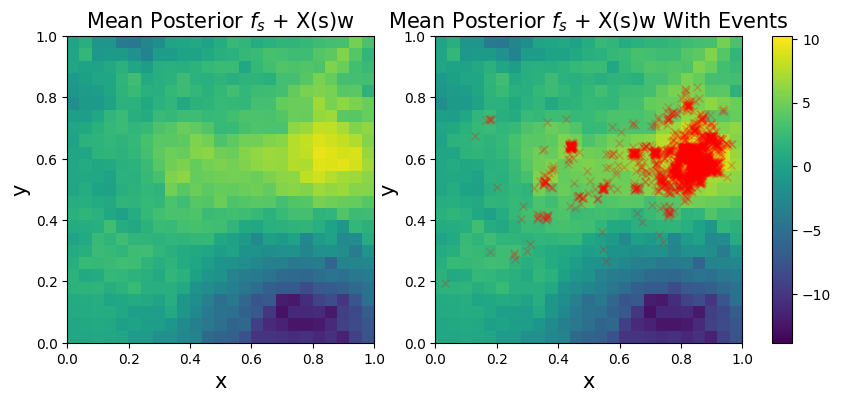

In [8]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)